# Project 242

## Import

In [138]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [140]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


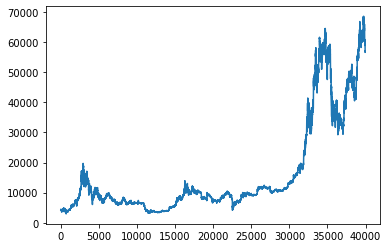

In [141]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [142]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})

Here, we can decide to add features ...

In [143]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [144]:
data.loc[data['VWAP'].isna(), 'VWAP'] = 0

In [145]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 13) | X_test: (9978, 13)


In [146]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [147]:
train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)

## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [148]:
train = prepare_data_2D_format(train_data, lookback_period = 2, undersample = False)
test = prepare_data_2D_format(test_data, lookback_period = 2, undersample = False)
test = test[:-10]

X_train = train
X_train = X_train.drop(['Signal'], axis = 1)
y_train = train['Signal']

X_test = test
X_test = X_test.drop(['Signal'], axis = 1)
y_test = test['Signal']

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# ccp_alpha values
grid_values = {'ccp_alpha': np.linspace(0, 0.003, 20),
              'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

# Regression Tree
dtc = DecisionTreeClassifier()

# Regression Tree for all ccp_alpha
dtc_cv = GridSearchCV(dtc, param_grid=grid_values, scoring='accuracy', cv=5, verbose=1)
dtc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00015789, 0.00031579, 0.00047368, 0.00063158,
       0.00078947, 0.00094737, 0.00110526, 0.00126316, 0.00142105,
       0.00157895, 0.00173684, 0.00189474, 0.00205263, 0.00221053,
       0.00236842, 0.00252632, 0.00268421, 0.00284211, 0.003     ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

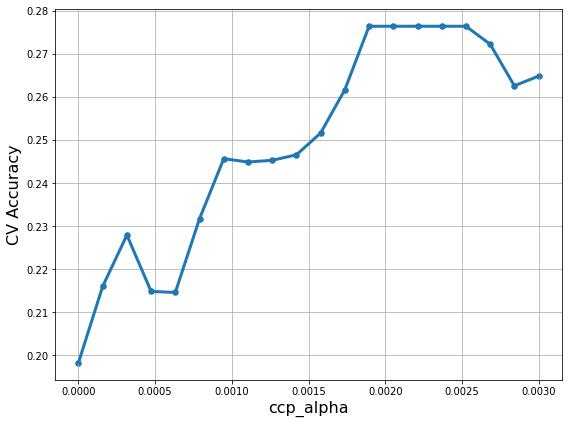

In [150]:
## The goal here is to plot accuracy scores with respect to ccp_alpha, to justify my choice
import matplotlib.pyplot as plt

acc_scores = dtc_cv.cv_results_['mean_test_score']
ccp_alpha = dtc_cv.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV Accuracy', fontsize=16)
plt.scatter(ccp_alpha,acc_scores, s=30)
plt.plot(ccp_alpha, acc_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [151]:
print('Best ccp_alpha: ', dtc_cv.best_params_['ccp_alpha'])
print('Best Accuracy: ', dtc_cv.best_score_)

Best ccp_alpha:  0.0018947368421052633
Best Accuracy:  0.2763537154165448


Node count: 9


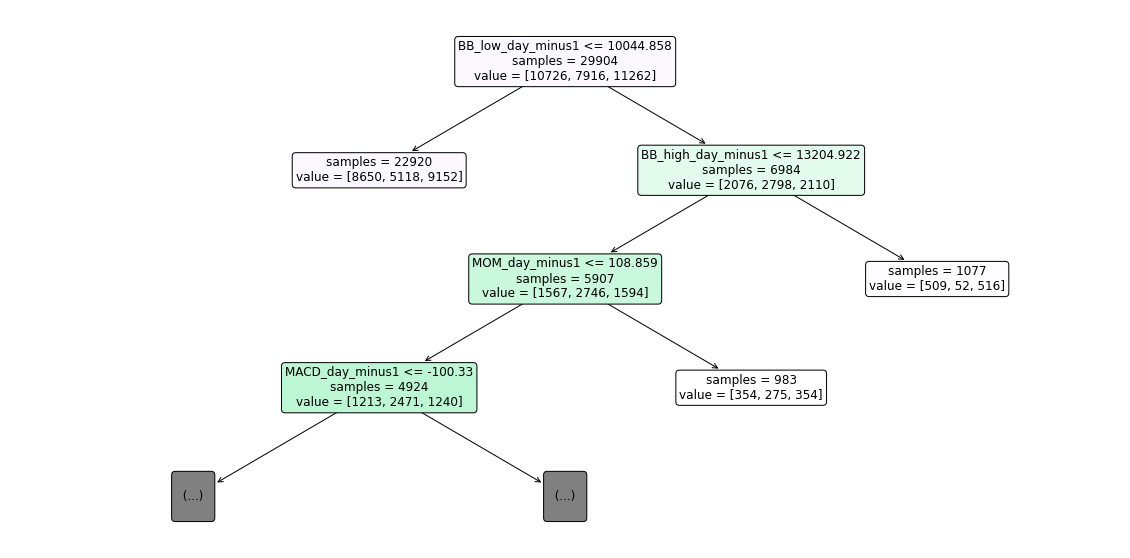

In [152]:
from sklearn.tree import plot_tree
print('Node count:', dtc_cv.best_estimator_.tree_.node_count)
plt.figure(figsize=(20,10))
plot_tree(dtc_cv.best_estimator_, feature_names=X_train.columns, filled=True,impurity=False, rounded=True,
        fontsize=12, max_depth=3)
plt.show()

In [153]:
y_pred = dtc_cv.best_estimator_.predict(X_test)

### 3. Test prediction model

In [154]:
TPR = get_TPR_FPR(y_test, y_pred)[0]
FPR = 0
F1 = get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data['close'])

### 4. Vanilla Bagging of CART

In [167]:
from sklearn.ensemble import RandomForestClassifier
cart_van = RandomForestClassifier(max_features=len(X_train.columns), min_samples_leaf=5, n_estimators = 500, random_state=88, verbose=0)
cart_van.fit(X_train, y_train)

RandomForestClassifier(max_features=26, min_samples_leaf=5, n_estimators=500,
                       random_state=88)

In [171]:
y_pred_van = cart_van.predict(X_test)

TPR_van = get_TPR_FPR(y_test, y_pred_van)[0]
FPR_van = 0
F1_van = get_F1(y_test, y_pred_van)
ACC_van = get_ACC(y_test, y_pred_van)
WACC_van = 0#get_WACC(y_test, y_pred_van, test_data['close'])

In [172]:
models = ['CART', 'CART w Vanilla Bagging']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC], 
              [TPR_van, FPR_van, ACC_van, F1_van, WACC_van]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,TPR,FPR,ACC,F1,WACC
CART,0.339301,0,0.422135,0.211201,0
CART w Vanilla Bagging,0.344249,0,0.401666,0.242178,0


### III. Strategy

### 1. Get data ready for backtesting

In [173]:
signal = pd.Series(y_pred)
close = test_data.close

signal_v = pd.Series(y_pred_van)

In [174]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
signal_crop_v = crop_window(signal_v, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [175]:
strat = Strategy(cash=500, fees=0.001)

In [176]:
strat.run(signal_crop, close_crop, verbose=False)

In [177]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

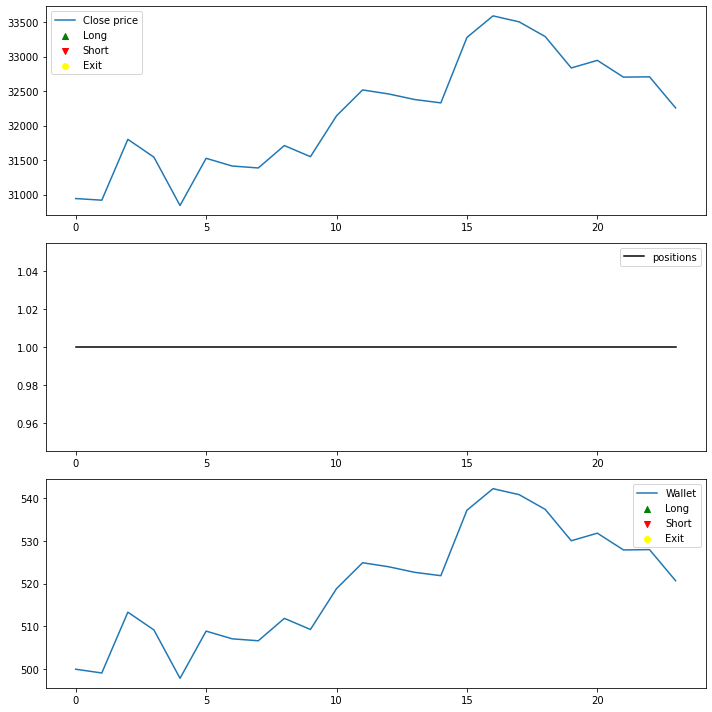

In [178]:
strat.visualize()

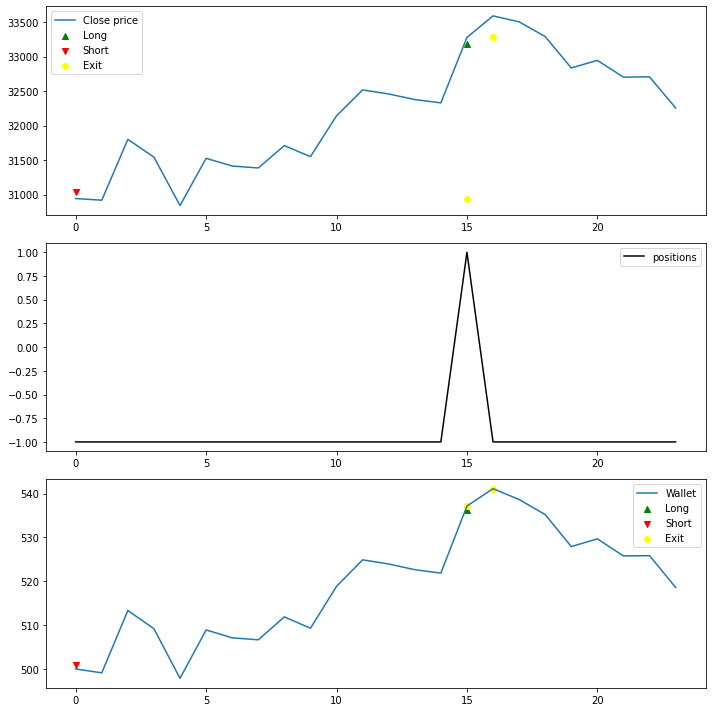

In [179]:
strat_v = Strategy(cash=500, fees=0.001)
strat_v.run(signal_crop_v, close_crop, verbose=False)
wallet_v = np.array(strat_v.wallet)
profit_list = [0]
for i in range(1, len(wallet_v)):
    profit_list.append(wallet_v[i]-wallet_v[i-1])
    
profit_v = np.array(profit_list)
strat_v.visualize()

### 3. Test performance startegy

In [180]:
c_SharpeRatio = SharpeRatio(profit)
c_MaxDrawback = MaxDrawback(profit)
c_WinLossRatio = WinLossRatio(profit)
c_CumulativeProfit = CumulativeProfit(profit)
c_MeanProfit = MeanProfit(profit)

cv_SharpeRatio = SharpeRatio(profit_v)
cv_MaxDrawback = MaxDrawback(profit_v)
cv_WinLossRatio = WinLossRatio(profit_v)
cv_CumulativeProfit = CumulativeProfit(profit_v)
cv_MeanProfit = MeanProfit(profit_v)

In [181]:
models = ['CART', 'CART w Vanilla Bagging']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[c_SharpeRatio, c_MaxDrawback, c_WinLossRatio, c_CumulativeProfit, c_MeanProfit],
              [cv_SharpeRatio, cv_MaxDrawback, cv_WinLossRatio, cv_CumulativeProfit, cv_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)

,SharpeRatio,MaxDrawback,WinLossRatio,CumulativeProfit,MeanProfit
CART,0.129540,-11.304506,0.642857,20.691227,0.827649
CART w Vanilla Bagging,0.116709,-11.304506,0.642857,18.610545,0.744422
